In [82]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import shutil 
from tqdm import tqdm
import os
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
import random
import subprocess
import cv2
from PIL import Image

from torchvision import transforms, models
import warnings
warnings.filterwarnings('ignore')

In [76]:
SEED = 15
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [77]:
data_root = '/kaggle/input/chestxraydataset/chest_xray'
print(os.listdir(data_root)) # проверяем, какие есть директории

['test', 'train']


In [78]:
train_dir = 'train'
val_dir = 'val'
each_val_img_ind = 50  # Валидация каждое 50-ое изображение будем класть в валидацию

class_names = ['NORMAL', 'PNEUMONIA']

# Создаем директории для train, val и virus
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
    os.makedirs(os.path.join(dir_name, 'VIRUS'), exist_ok=True)  # Создаем папку virus

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if 'virus' in file_name:
            if i % each_val_img_ind != 0:
                dest_dir = os.path.join(train_dir, 'VIRUS')
            else:
                dest_dir = os.path.join(val_dir, 'VIRUS')
        else:
            if i % each_val_img_ind != 0:
                dest_dir = os.path.join(train_dir, class_name)
            else:
                dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
os.rename('/kaggle/working/train/PNEUMONIA', '/kaggle/working/train/BACT')
os.rename('/kaggle/working/val/PNEUMONIA', '/kaggle/working/val/BACT')
class_names[1] = 'BACT'
class_names.append('VIRUS')

100%|██████████| 3875/3875 [00:07<00:00, 528.42it/s]


In [79]:
!dir train 

BACT  NORMAL  VIRUS


[2478, 1319, 1314]


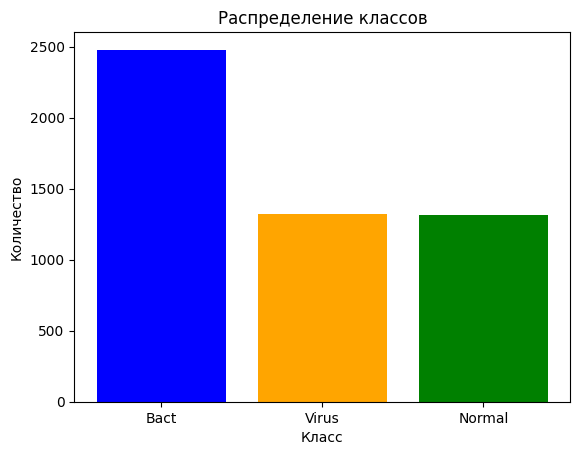

In [80]:
def print_data():
    virus = len(os.listdir('/kaggle/working/train/VIRUS'))
    bact = len(os.listdir('/kaggle/working/train/BACT'))
    normal = len(os.listdir('/kaggle/working/train/NORMAL'))
    labels = ['Bact', 'Virus', 'Normal']
    values = [bact, virus, normal]
    print(values)
    plt.bar(labels, values, color=['blue', 'orange', 'green'])
    plt.title('Распределение классов')
    plt.xlabel('Класс')
    plt.ylabel('Количество')
    plt.show()
print_data()

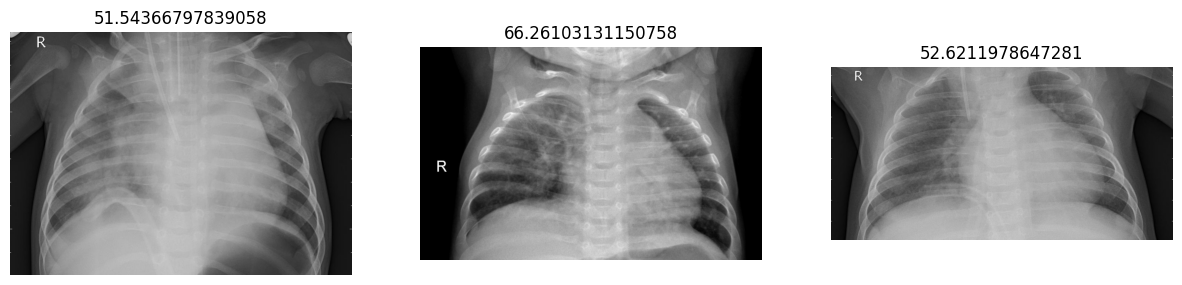

In [83]:
def calculate_contrast(image): 
    image = np.array(image)
    if len(image.shape) == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image

    contrast = np.std(image_gray)
    return contrast

def show_images_for_comparison(folder_path):
    images = []
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    for file_name in image_files[21:24]:
        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path).convert('RGB')
        images.append(image)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for ax, img, file_name in zip(axes, images, image_files[:3]):
        ax.imshow(img)
        ax.set_title(calculate_contrast(img))
        ax.axis('off')
    plt.show()

folder_path = '/kaggle/input/chestxraydataset/chest_xray/test/PNEUMONIA/'
show_images_for_comparison(folder_path)


In [81]:
def get_images_contrast(folder_path):
    contrasts = []
    
    for root, _, files in os.walk(folder_path):
        print(root)
        for file in files:
            image_path = os.path.join(root, file)
            image = cv2.imread(image_path)

            if image is not None:
                contrast = calculate_contrast(image)
                contrasts.append(contrast)
                    
    result_tensor = torch.tensor(contrasts)
    return result_tensor

folder_path = '/kaggle/working/train/'
contrast_tensor = get_images_contrast(folder_path)


/kaggle/working/train/
/kaggle/working/train/VIRUS
/kaggle/working/train/NORMAL
/kaggle/working/train/BACT


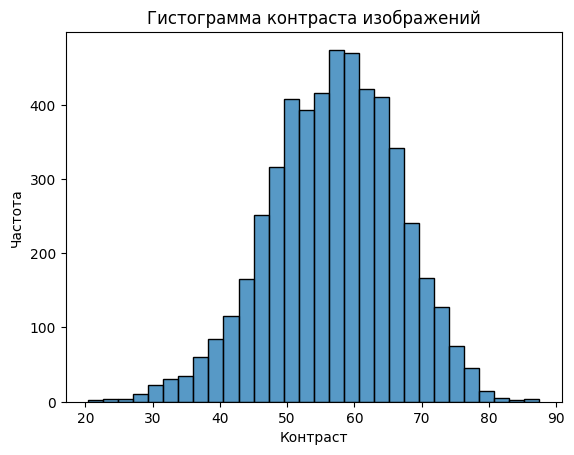

In [84]:
sns.histplot(contrast_tensor.numpy(), bins=30)
plt.xlabel('Контраст')
plt.ylabel('Частота')
plt.title('Гистограмма контраста изображений')
plt.show()


In [85]:
def adjust_contrast_my(image, factor):
    return adjust_contrast(image, factor)

transform = [
    transforms.Compose([
        transforms.Lambda(lambda x: adjust_contrast_my(x, 2 if calculate_contrast(x) < 55 else 1)),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    transforms.Compose([
        transforms.Lambda(lambda x: adjust_contrast_my(x, 1.5 if calculate_contrast(x) < 55 else 1)),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
]

test_transform = [
     transforms.Compose([
        transforms.Lambda(lambda x: adjust_contrast_my(x, 2 if calculate_contrast(x) < 55 else 1)),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
]

train_dataset = torch.utils.data.ConcatDataset([torchvision.datasets.ImageFolder(train_dir, train_transform)
                                                    for train_transform in transform])
#применяем все аугментации

val_dataset = torch.utils.data.ConcatDataset([torchvision.datasets.ImageFolder(val_dir, train_transform)
                                                    for train_transform in transform])

batch_size = 20
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [86]:
print("train size : {} val size : {}".format(len(train_dataloader), len(val_dataloader)))

train size : 512 val size : 11


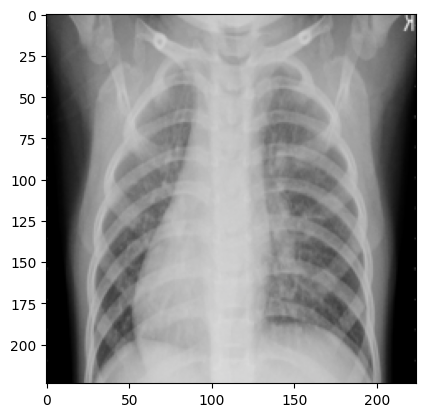

In [87]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

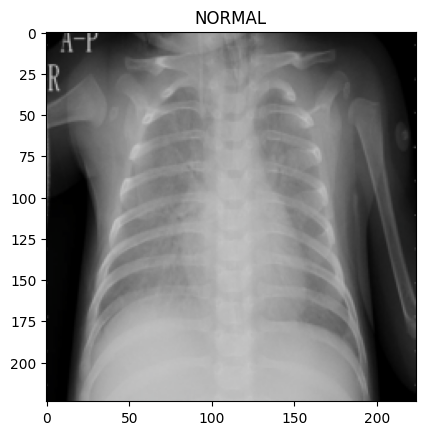

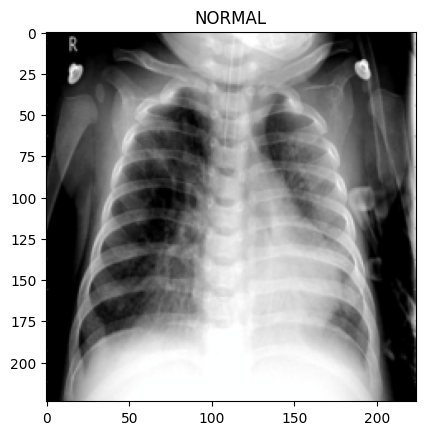

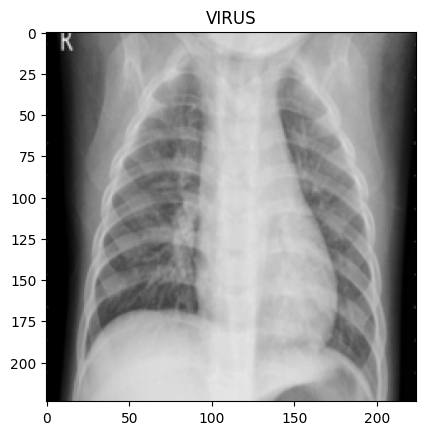

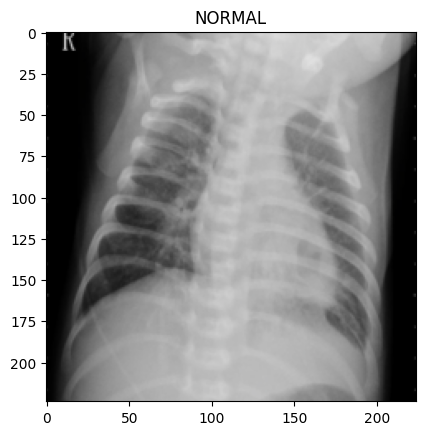

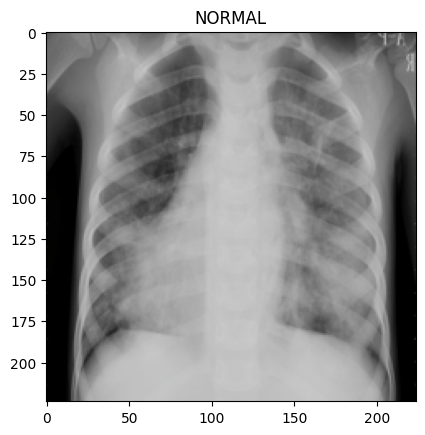

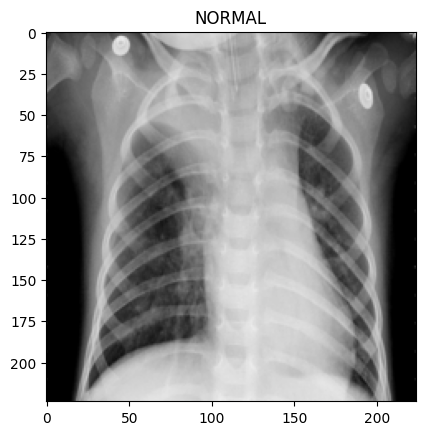

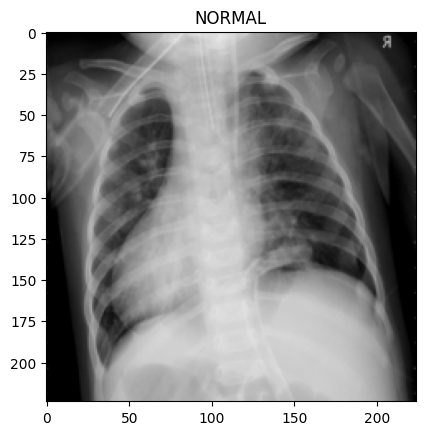

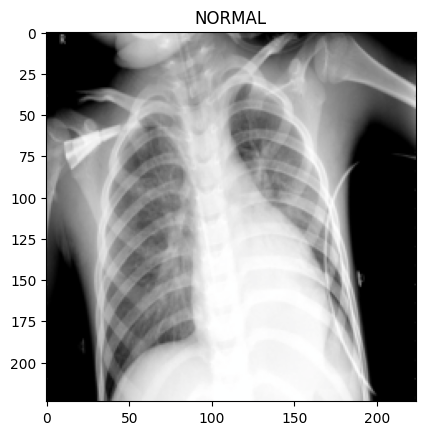

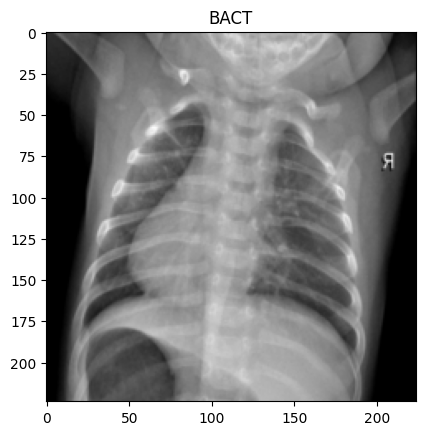

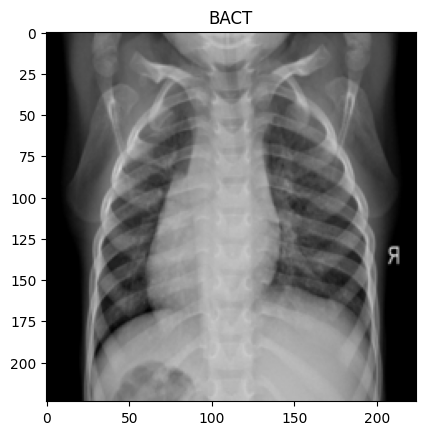

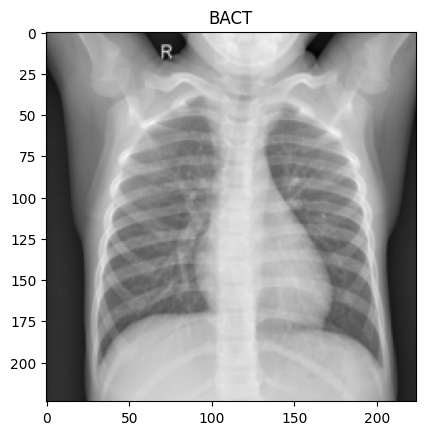

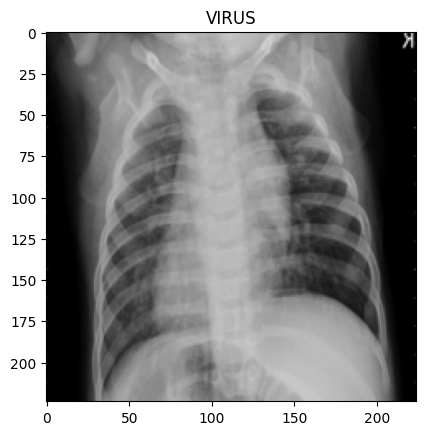

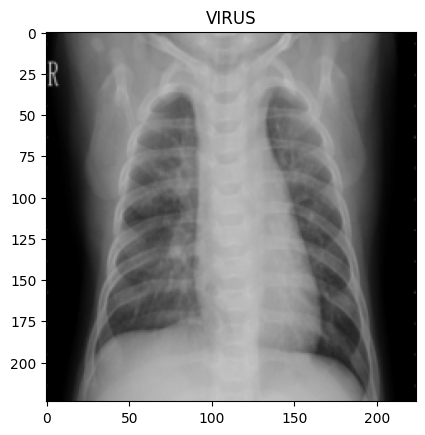

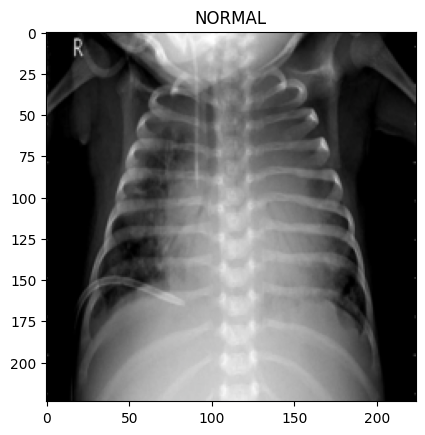

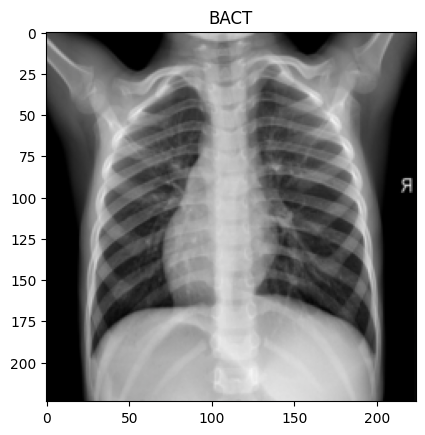

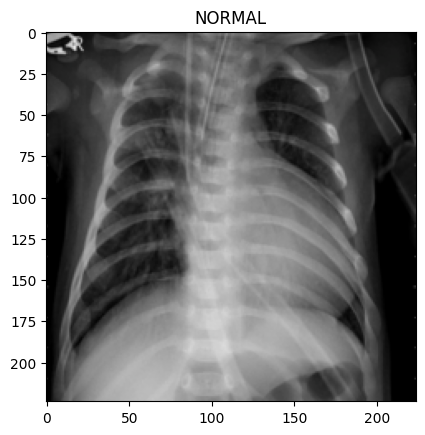

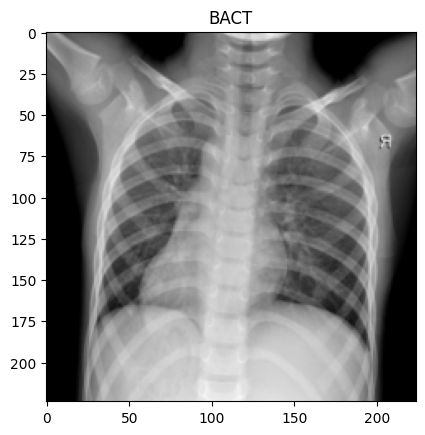

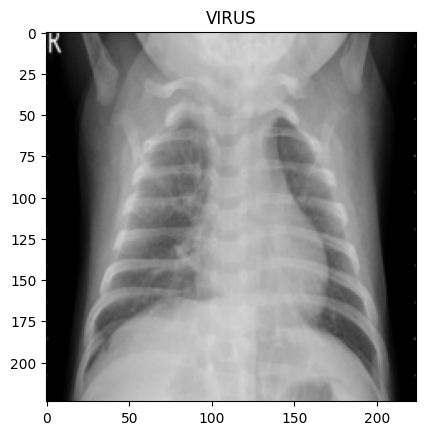

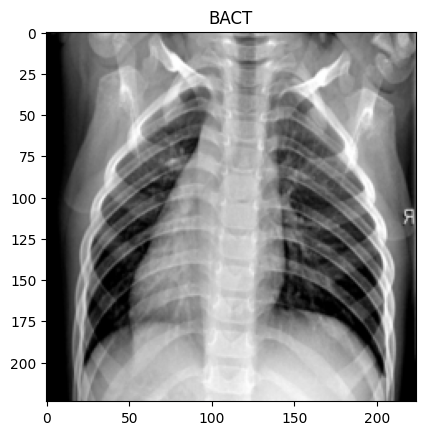

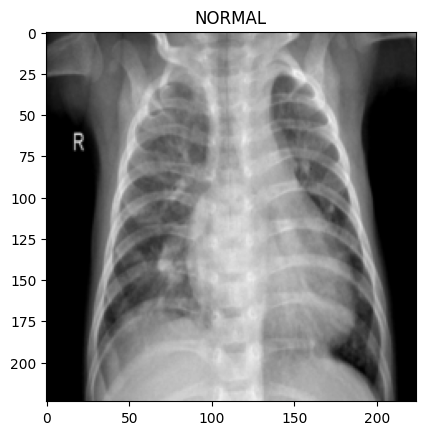

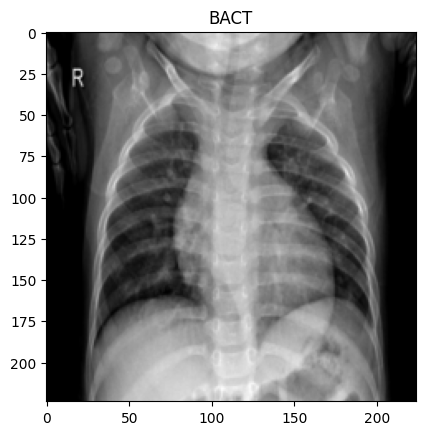

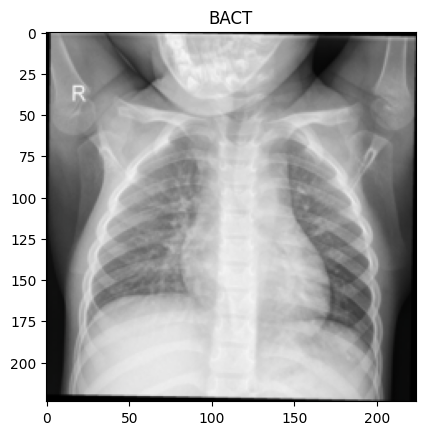

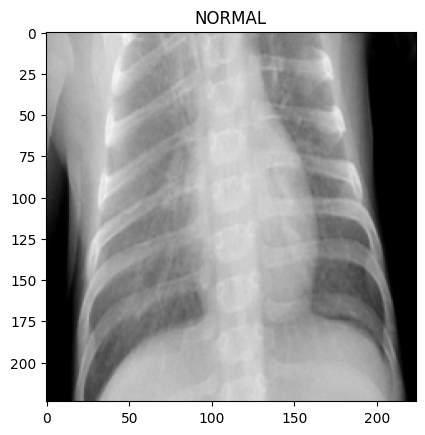

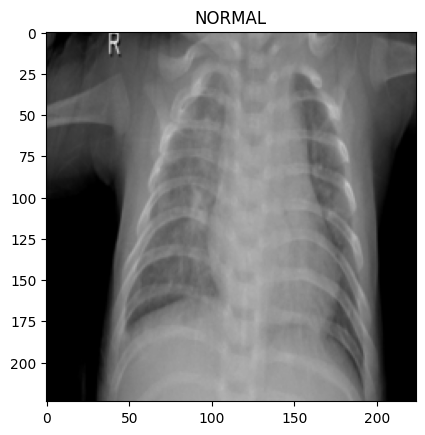

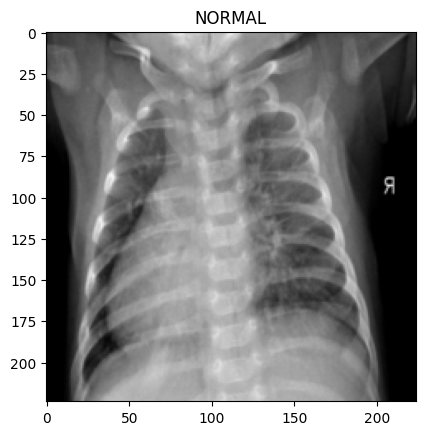

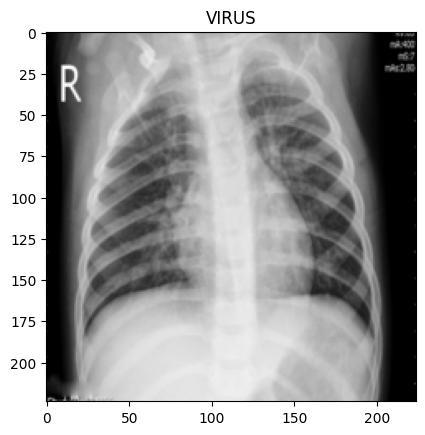

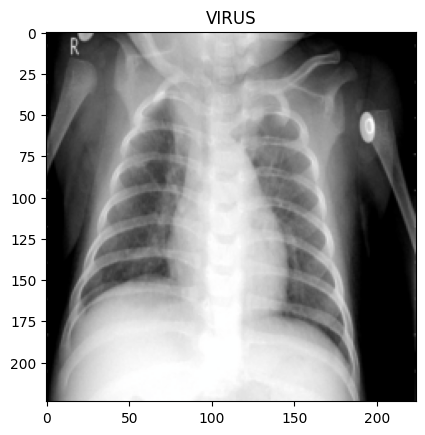

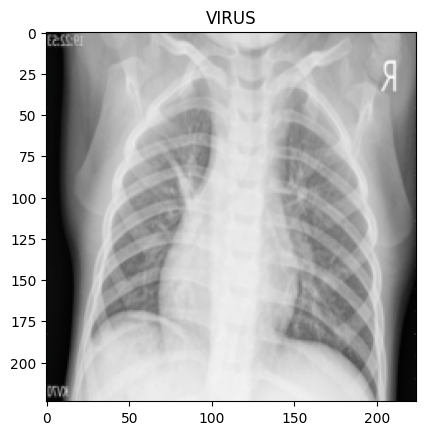

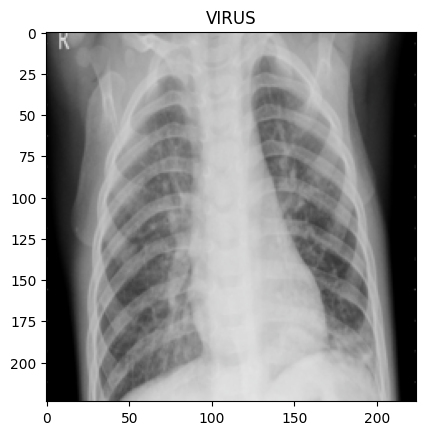

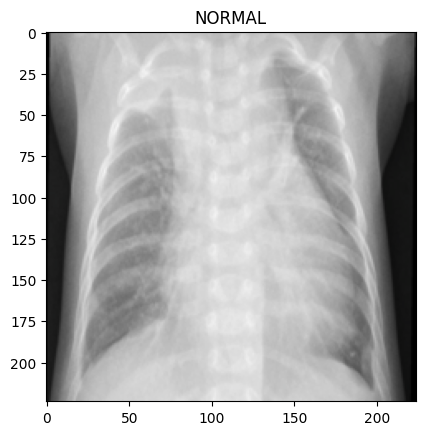

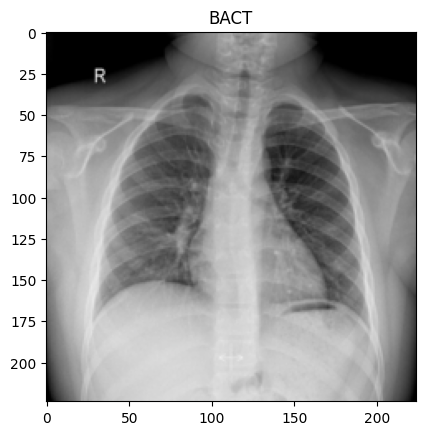

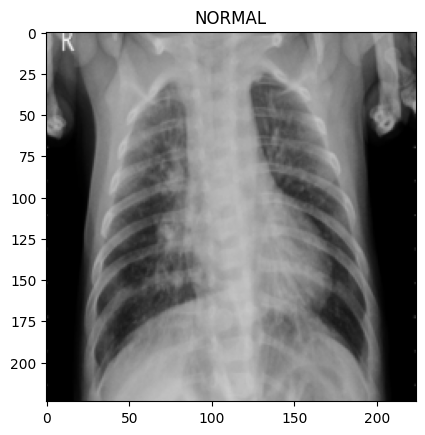

In [64]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [88]:
class CustomNeuralNetResNet(torch.nn.Module):
    def __init__(self,outputs_number):
        super(CustomNeuralNetResNet, self).__init__()
#         self.net = models.resnet18(pretrained=False)
        self.net = models.resnet50(pretrained=False)
        
#         self.net = models.resnet101(pretrained=True)
        
#         for param in self.net.parameters():
#             param.requires_grad = False

#         TransferModelOutputs = self.net.fc.in_features
#         self.net.fc = torch.nn.Sequential(
#             torch.nn.Linear(TransferModelOutputs, outputs_number))
#         

    def forward(self, x):
        return self.net(x)

In [89]:
model = CustomNeuralNetResNet(3)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
# loss = torch.nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True) # смотреть предыдущие градиенты для лучшей сходимости
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.2)


# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [90]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    best_val_loss = float('inf')
    best_val_acc = 0
    best_model_weights = None
    train_loss = torch.zeros(num_epochs)
    val_loss = torch.zeros(num_epochs)
    train_acc = torch.zeros(num_epochs)
    val_acc = torch.zeros(num_epochs)
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()

            running_loss = 0.
            running_acc = 0.

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
#                     log_probs = torch.nn.functional.log_softmax(preds, dim=1)
#                     loss_value = loss(log_probs, labels)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                train_loss[epoch] = epoch_loss
                train_acc[epoch] = epoch_acc
            else:
                val_loss[epoch] = epoch_loss
                val_acc[epoch] = epoch_acc
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_val_acc =  epoch_acc
                    best_model_weights = model.state_dict()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
    if best_model_weights is not None:
        torch.save(best_model_weights, 'best_model.pth')
        print('Best model saved with loss:', best_val_loss, best_val_acc)

    return train_loss, val_loss, train_acc, val_acc

In [91]:
train_loss, val_loss, train_acc, val_acc = train_model(model, loss, optimizer, scheduler, num_epochs=5)

Epoch 0/4:


100%|██████████| 512/512 [02:46<00:00,  3.07it/s]

train Loss: 0.7082 Acc: 0.6930



100%|██████████| 11/11 [00:04<00:00,  2.56it/s]

val Loss: 0.6540 Acc: 0.6864
Epoch 1/4:



100%|██████████| 512/512 [02:46<00:00,  3.08it/s]

train Loss: 0.5297 Acc: 0.7641



100%|██████████| 11/11 [00:04<00:00,  2.59it/s]

val Loss: 0.5847 Acc: 0.7864
Epoch 2/4:



100%|██████████| 512/512 [02:46<00:00,  3.08it/s]

train Loss: 0.4991 Acc: 0.7751



100%|██████████| 11/11 [00:04<00:00,  2.62it/s]

val Loss: 0.5940 Acc: 0.7500
Epoch 3/4:



100%|██████████| 512/512 [02:46<00:00,  3.07it/s]

train Loss: 0.4607 Acc: 0.7938



100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

val Loss: 0.6791 Acc: 0.7591
Epoch 4/4:



100%|██████████| 512/512 [02:46<00:00,  3.08it/s]

train Loss: 0.3878 Acc: 0.8327



100%|██████████| 11/11 [00:04<00:00,  2.62it/s]

val Loss: 0.5263 Acc: 0.8045


Best model saved with loss: 0.5262553217736158 tensor(0.8045, device='cuda:0')


In [ ]:
import gc

def clear_gpu_memory():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect() 

In [ ]:
train_loss_list = list()
val_loss_list = list()
train_acc_list = list()
val_acc_list = list()

In [ ]:
train_loss_list.append(train_loss.numpy())
val_loss_list.append(val_loss.numpy())
train_acc_list.append(train_acc.numpy())
val_acc_list.append(val_acc.numpy())

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(25, 10))
# title = ['NLLLoss + SGD', 'NLLLoss + Adam', 'CrossEntropyLoss + SGD', 'CrossEntropyLoss + Adam']
title = ['resnet50', 'resnet50 pret', 'resnet101 pret', 'resnet101 pret']


for i in range(4):
    # Графики потерь
    axs[0][i].plot(train_loss_list[i], label='train loss')
    axs[0][i].plot(val_loss_list[i], label='val loss')
    axs[0][i].set_title(f'{title[i]} Loss')
    axs[0][i].legend(loc='best')
    
    # Графики точности
    axs[1][i].plot(train_acc_list[i], label='train acc')
    axs[1][i].plot(val_acc_list[i], label='val acc')
    axs[1][i].set_title(f'{title[i]} Accuracy')
    axs[1][i].legend(loc='best')

fig.suptitle('Comparison', fontsize=16)
plt.tight_layout()
plt.show()

In [92]:
train_loss = train_loss.numpy()
val_loss = val_loss.numpy()
train_acc = train_acc.numpy()
val_acc = val_acc.numpy()

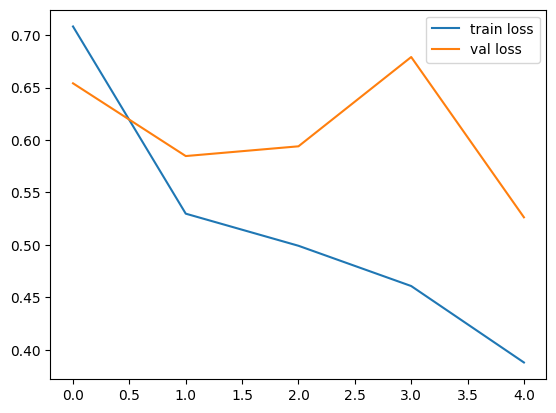

In [93]:
plt.plot(train_loss, label = 'train loss')
plt.plot(val_loss, label = 'val loss')
plt.legend(loc='best')
plt.show()

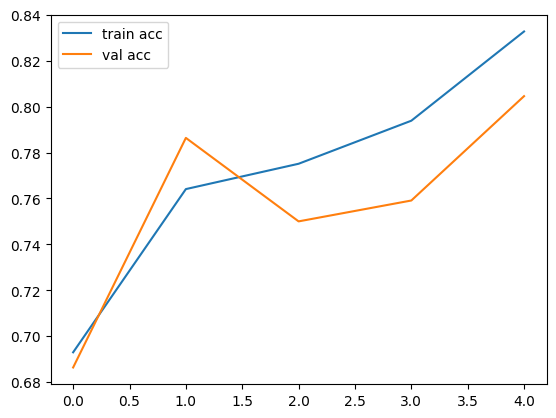

In [94]:
plt.plot(train_acc, label = 'train acc')
plt.plot(val_acc, label = 'val acc')
plt.legend(loc='best')
plt.show()

100%|██████████| 11/11 [00:04<00:00,  2.49it/s]


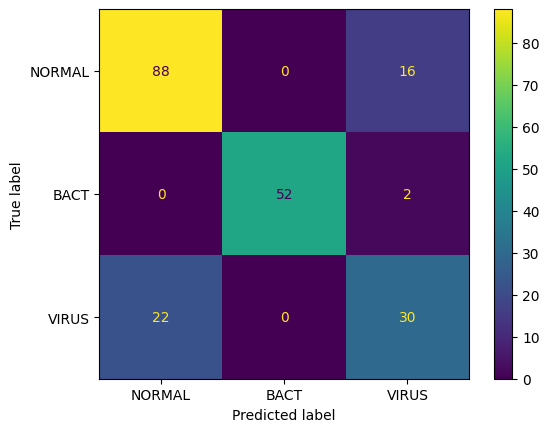

In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            preds = model(inputs)
            preds_class = preds.argmax(dim=1)
            all_preds.extend(preds_class.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

def plot_confusion_matrix(labels, preds, class_names):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()

all_labels, all_preds = evaluate_model(model, val_dataloader)
plot_confusion_matrix(all_labels, all_preds, class_names)

In [96]:
data_root = '/kaggle/input/test-pnemonia'
test_dir = 'test'
shutil.copytree(os.path.join(data_root), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [99]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_data = 'test/'
test_dataset = ImageFolderWithPaths(test_data, test_transform[0])

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [100]:
def get_predictions(dataloader):
    model.eval()
    test_predictions = []
    test_img_paths = []
    for inputs, labels, paths in tqdm(dataloader):
        inputs = inputs.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs)
        # Используем softmax для получения вероятностей классов
        preds = torch.nn.functional.softmax(preds, dim=1).data.cpu().numpy()
        test_predictions.append(preds)
        test_img_paths.extend(paths)

    test_predictions = np.concatenate(test_predictions)
    return test_predictions, test_img_paths

test_predictions, test_img_paths = get_predictions(test_dataloader)

100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


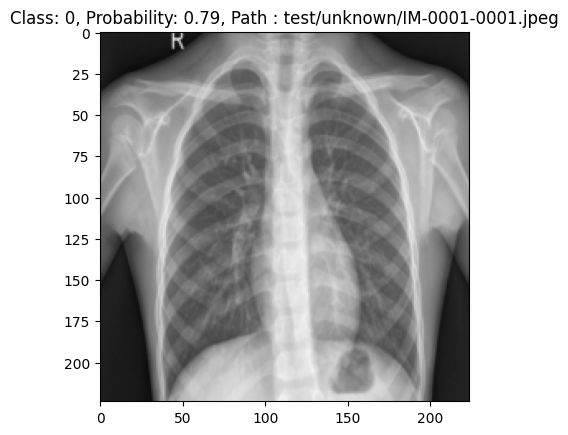

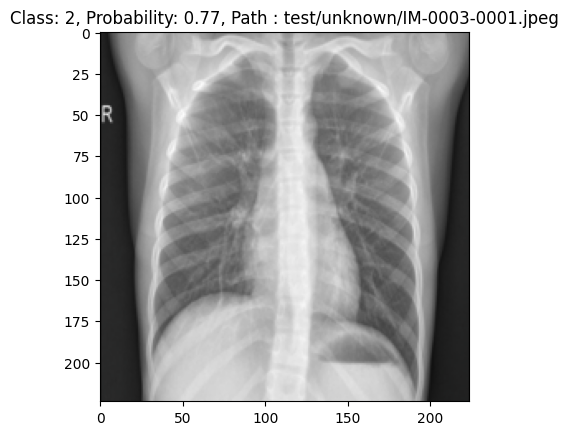

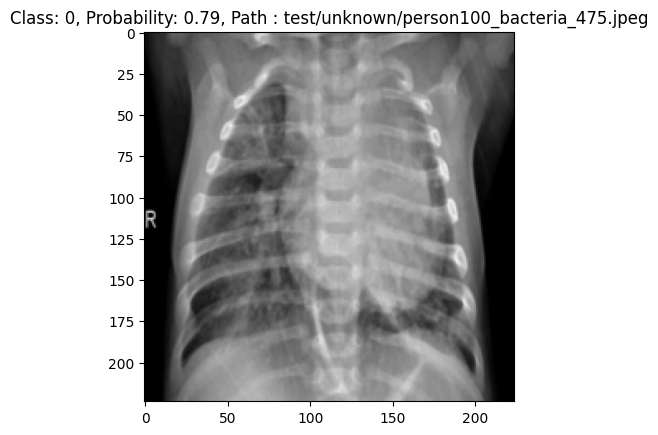

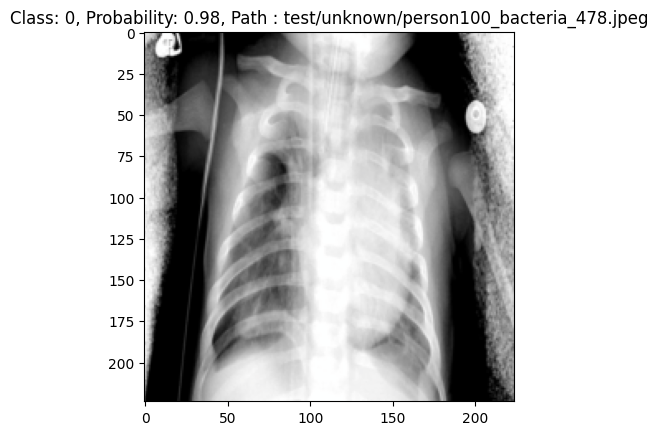

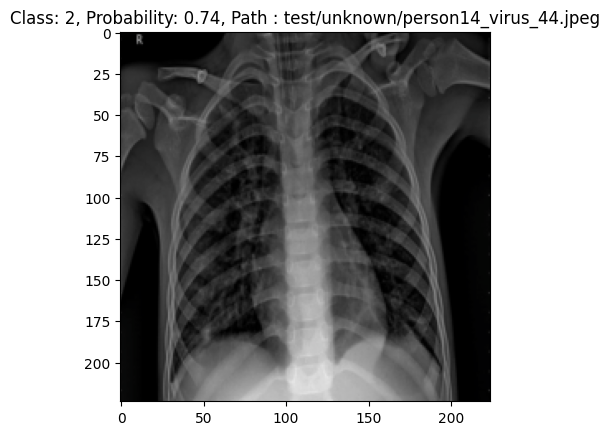

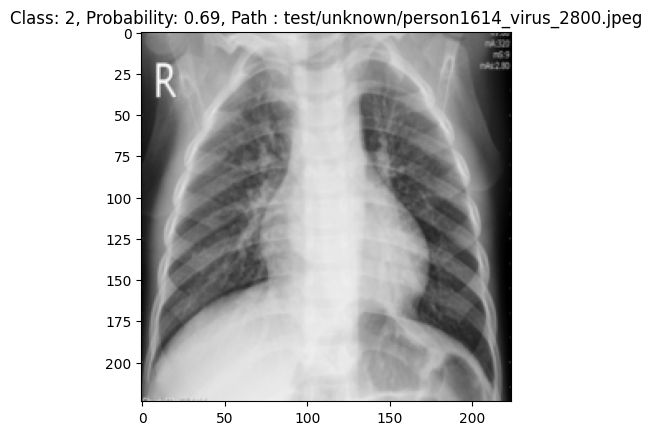

In [101]:
n_images = 1
iter_obj = iter(test_dataloader)

for _ in range(n_images):
    inputs, labels, paths = next(iter_obj)
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    for i, (img, pred) in enumerate(zip(inputs, preds)):
        pred = torch.nn.functional.softmax(pred, dim=0).data.cpu().numpy()
        img = img.cpu()
        predicted_class = np.argmax(pred)
        probability = pred[predicted_class]
        
        title = f'Class: {predicted_class}, Probability: {probability:.2f}, Path : {paths[i]}'
        show_input(img, title=title)


KeyboardInterrupt: 

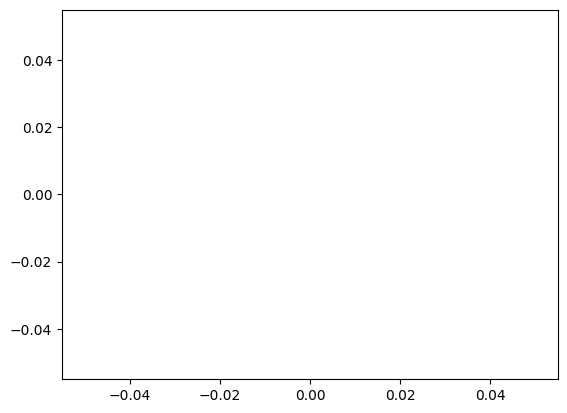

In [103]:
sns.histplot(test_predictions)

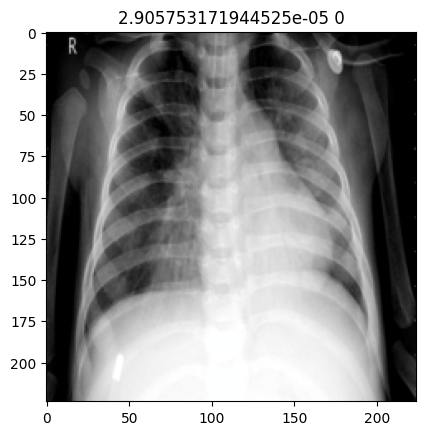

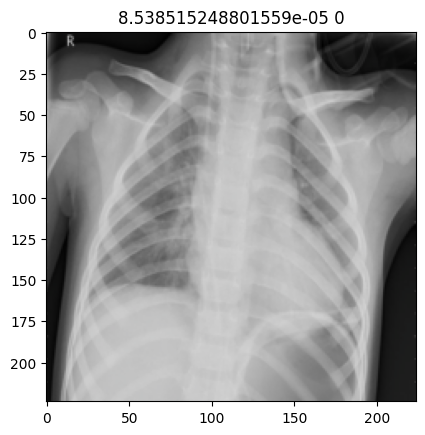

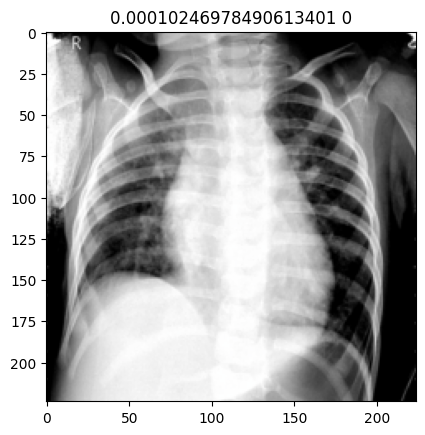

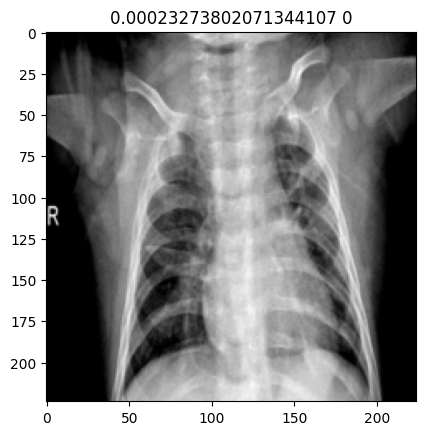

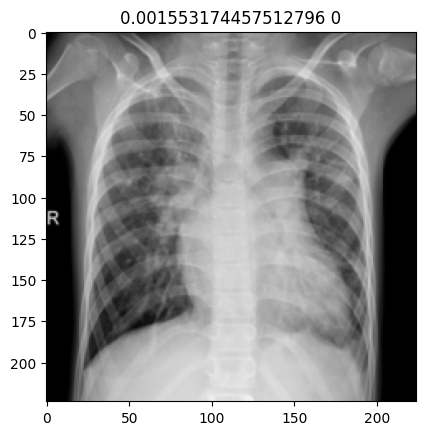

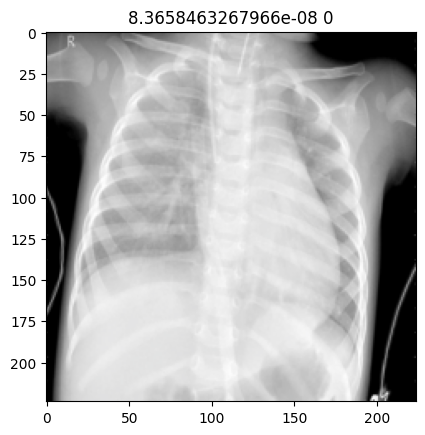

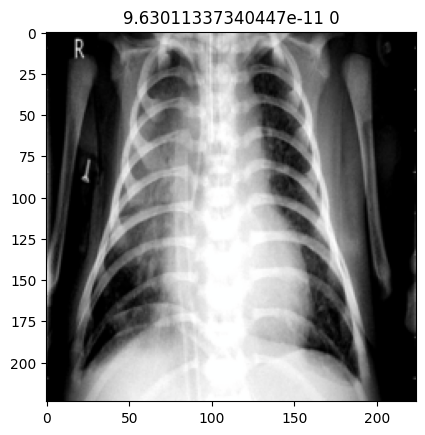

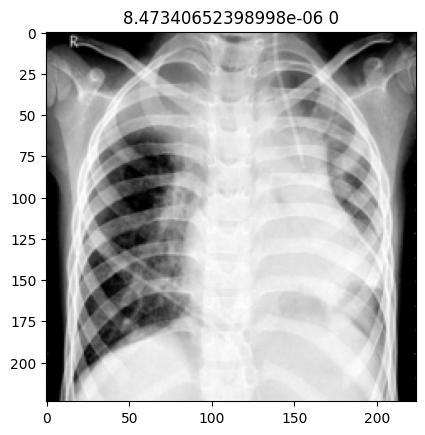

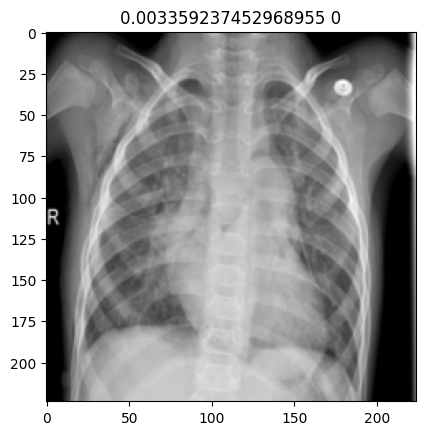

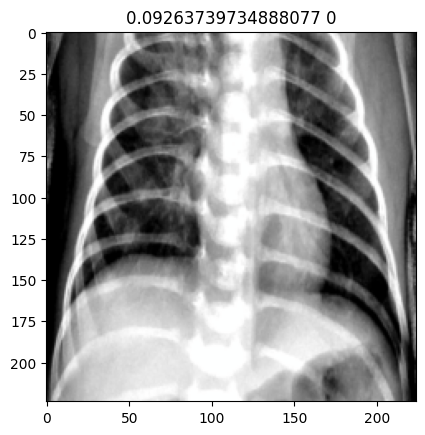

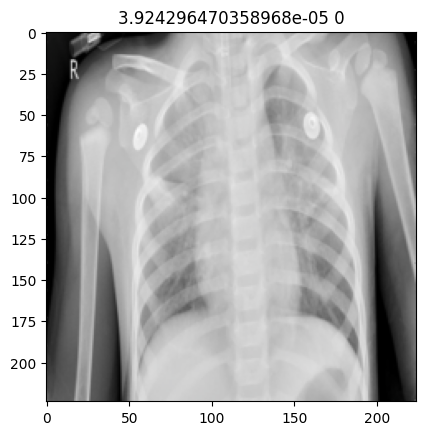

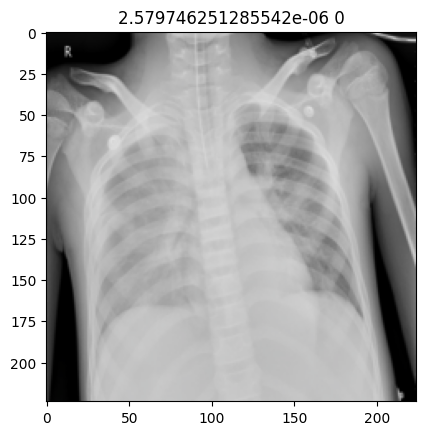

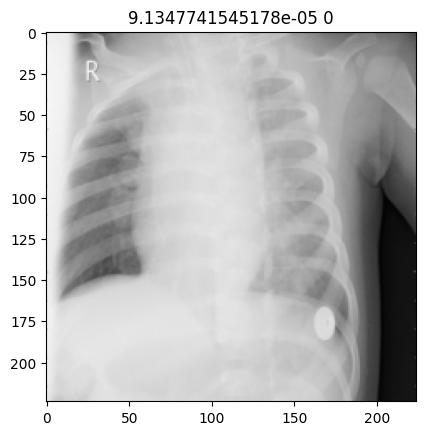

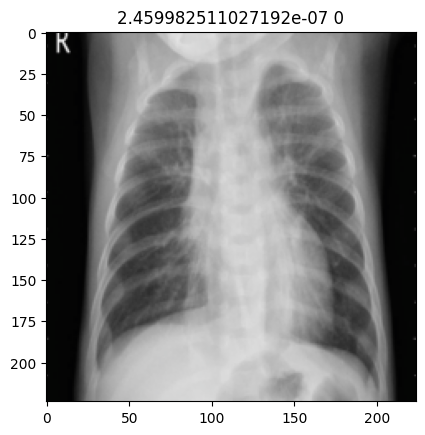

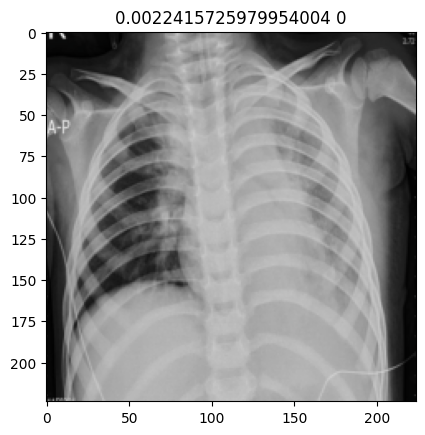

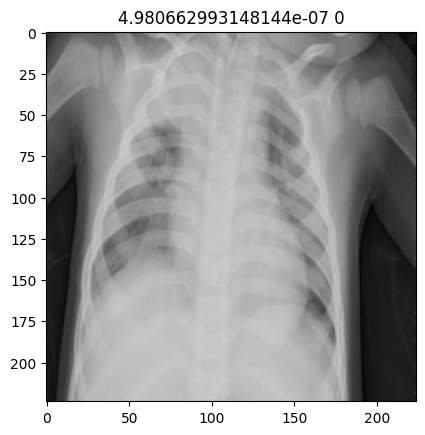

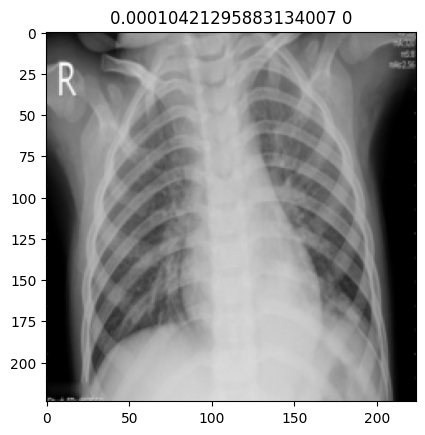

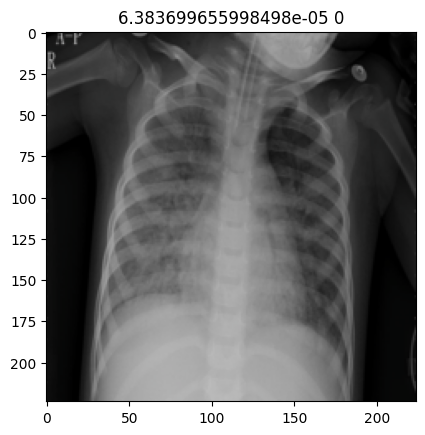

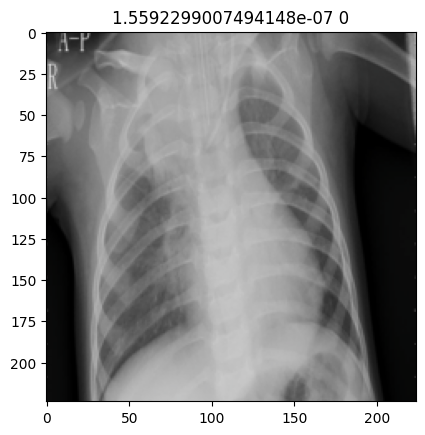

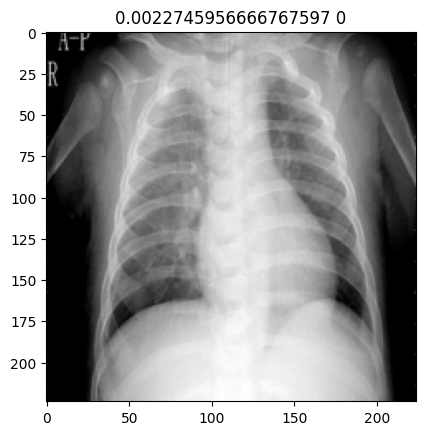

In [104]:
n_images = 1
iter_obj = iter(val_dataloader)

# X_batch, y_batch = next(iter(train_dataloader))

# for x_item, y_item in zip(X_batch, y_batch):
#     show_input(x_item, title=class_names[y_item])

dirty_probs = []
clean_probs = []

for _ in range(n_images):
    X_batch, y_batch = next(iter(iter_obj))
    X_batch = X_batch.to(device)
    with torch.set_grad_enabled(False):
        preds = model(X_batch)
    for img, pred_label in zip(X_batch, zip(preds, y_batch)):
            pred, label = pred_label
            pred = torch.nn.functional.softmax(pred).data.cpu().numpy()
            pred = pred[1]
            img = img.cpu()
            show_input(img, title="{} {}".format(pred, label))

In [75]:
import os
import shutil

files = os.listdir('/kaggle/working/')

# Удаляем каждый файл и директорию
for file in files:
    if os.path.isfile(file):
        os.remove(file)  # Удалить файл
    else:
        shutil.rmtree(file)  # Удалить директорию
